Import

In [50]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, roc_curve, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer, LabelBinarizer
import category_encoders

import time 
import pickle

from functools import partial 

import matplotlib.pyplot as plt 
%matplotlib inline 

Fuctions

In [257]:

def learning_curve_cv(X, y, model, train_size, cv=3):
    
    transform = partial(transform_custom, feature_names=list(X.columns))    
    train_size = np.int32(train_size)
    kf = StratifiedKFold(cv, random_state=42, shuffle=True)
    
    train_scores = np.zeros((len(train_size), cv), dtype=np.float32)
    valid_scores = np.zeros((len(train_size), cv), dtype=np.float32)    
    
    X, y = np.array(X), np.array(y).reshape(-1)
    
    for j, num in enumerate(train_size):
        print(j, num)
        for i, (train_index, val_index) in enumerate(kf.split(X[:num, :], y[:num])):

            print( "Fold ", i)

            y_train, y_val = y[train_index].copy(), y[val_index].copy()
            X_train, X_val = X[train_index, :].copy(), X[val_index, :].copy()
            
            X_train, X_val = transform(X_train, X_val, y_train)
            
            fit_model = model.fit(X_train, y_train)
            
            train_proba = fit_model.predict_proba(X_train)[:, 1]
            val_proba = fit_model.predict_proba(X_val)[:, 1]

            train_scores[j, i] = roc_auc_score(y_train, train_proba)
            valid_scores[j, i] = roc_auc_score(y_val, val_proba)
        
    return train_scores, valid_scores


def cross_val(X, y, model, kf, preprocessing, verbose=False):
    
    X, y = np.array(X), np.array(y).reshape(-1)
    cv_scores = []

    for i, (train_index, val_index) in enumerate(kf.split(X, y)):

        print( "Fold ", i)

        y_train, y_val = y[train_index].copy(), y[val_index].copy()
        X_train, X_val = X[train_index, :].copy(), X[val_index, :].copy()
        
        X_train, X_val = preprocessing(X_train, X_val, y_train)
        if verbose: print(X_train.shape)
            
        fit_model = model.fit(X_train, y_train)
        pred = fit_model.predict_proba(X_val)[:, 1]
        
        cv_scores.append(roc_auc_score(y_val, pred))
        
    return cv_scores

def cutoff_metrics(y_valid, predict_proba, cutoff):
    for cut in cutoff:
        print("f1: {:.3f}\trecall: {:.3f}\tprecision: {:.3f}\tacc: {:.3f}\tcutoff: {:.3f} ".format(
            f1_score(y_valid, predict_proba > cut), 
            recall_score(y_valid, predict_proba > cut), 
            precision_score(y_valid, predict_proba > cut), 
            accuracy_score(y_valid, predict_proba>cut),
            cut
        ))

def print_metrics(cv_scores):
    metrics = ['f1', 'precision', 'recall', 'roc auc']
    cvmean = cv_scores.mean(0)
    for i in range(4):
        print("{} = {:.5f}".format(metrics[i], cvmean[i]))

def transform(train, test, target, to_drop=False, 
              high_cardinality="smoothing", hc_treshold = 10, hc_drop=False, # high cardinality categorical
              eb_k=50, eb_f=10,  # parameters for hc smoothing function 
              encode=False,  # categorical 
              fill_num=-1, scaling=False,  # continuous 
              feature_names = False, feature_dtypes = False,
              keep = False
             ):
    
    """ 
    data preprocessing 
    
    :train, test: pandas DataFrame
    :high_cardinality: way to handle categorical features with high number of levels
    :encode: category encoding, 'ohe' = one hot, 'bin' = binary
    :fill_num: fill nan for continuous features, -1 = with -1, ('mean', 'median') = strategy
    :scaling: 'standard' = StandartScaler
    :feature_names: list, columns from dataframe
    :feature_dtypes: pd.Series, dtypes from dataframe
    
    category features should have type 'object'
    """
    
    # checks 
    
    feature_names = list(feature_names)
    if (isinstance(train, np.ndarray) or isinstance(test, np.ndarray)) and not feature_names:
        raise FeatureNamesError("Feature names had not defined for np.ndarray")
    
    # np to pd 
    if isinstance(train, np.ndarray):
        train=pd.DataFrame(train, columns=feature_names)
        dt = feature_dtypes.to_dict()
        for col in train.columns:
            train[col] = train[col].astype(dt[col])        
    if isinstance(test, np.ndarray):
        test=pd.DataFrame(test, columns=feature_names)
        dt = feature_dtypes.to_dict()
        for col in train.columns:
            test[col] = test[col].astype(dt[col])
    
    # remove duplicates 
    if to_drop:
        train = train.drop(to_drop, axis=1)
        test = test.drop(to_drop, axis=1)
    
    ######## categorical features 
    
    cat_features = train.columns[train.dtypes=='object']
    num_features = train.columns[train.dtypes!='object']      
    
    # factorize 
    le = LabelEncoder()
    train[cat_features] = train[cat_features].fillna('-1')
    test[cat_features] = test[cat_features].fillna('-1')
    for c in cat_features:
        data=train[c].append(test[c])
        le.fit(data.values.tolist())  # nan = 0 level
        train[c] = le.transform(train[c].values.tolist())
        test[c] = le.transform(test[c].values.tolist())       
    
    # mark nan with -1, if encoding not necessary 
    if not encode:
        train[cat_features] = train[cat_features].replace(0, -1)
        test[cat_features] = test[cat_features].replace(0, -1)    
        
    ######## high cardinality
    
    if high_cardinality:

        hc_features = train[cat_features].columns[train[cat_features].apply(lambda x: len(x.value_counts())) > hc_treshold]
        target_mean = target.mean()
        S = {}

        for c in hc_features:

            if high_cardinality == "sr":
                # supervised ratio 
                group_means = pd.concat([train[c], pd.DataFrame(target, columns=['target'], index=train.index)], axis=1).groupby(c).mean()
                group_means = group_means.target.to_dict()
                for group in train[c].value_counts().index:
                    S[group] = group_means[group]

            if high_cardinality=="woe":
                # weight of evidence
                group_y1 = pd.concat([train[c], pd.DataFrame(target, columns=['target'], index=train.index)], axis=1).\
                groupby([c]).agg('sum')
                group_y0 = pd.concat([train[c], pd.DataFrame(target, columns=['target'], index=train.index)], axis=1).\
                groupby([c]).agg('count') - group_y1
                y1 = (target==1).sum()
                y0 = (target==0).sum()
                woe = np.log(((group_y1) / y1) / ((group_y0) / y0))
                for i,v in zip(woe.index, np.where(np.isinf(woe), 0, woe)):
                    S[i] = v[0]

            if high_cardinality=="smoothing":
                # empirical bayes (smoothing for small group)
                group_means = pd.concat([train[c], pd.DataFrame(target, columns=['target'], index=train.index)], axis=1).groupby(c).mean()
                group_means = group_means.target.to_dict()
                group_counts = pd.concat([train[c], pd.DataFrame(target, columns=['target'], index=train.index)], axis=1).groupby(c).agg('count')
                group_counts = group_counts.target.to_dict()

                def smoothing_function(n, k, f):
                    return 1 / (1 + np.exp(-(n-k)/f))

                for group in train[c].value_counts().index:
                    lam = smoothing_function(n=group_counts[group], k=eb_k, f=eb_f)
                    S[group] = lam*group_means[group] + (1-lam)*target_mean

            # transform train
            train[c+'_avg'] = train[c].apply(lambda x: S[x]).copy()

            # transform test
            def hc_transform_test(x):
                if x in S: 
                    return S[x]
                else:
                    return target_mean

            test[c+'_avg'] = test[c].apply(hc_transform_test).copy()

        # drop hc features 
        if hc_drop:
            train.drop(hc_features, axis=1, inplace=True)
            test.drop(hc_features, axis=1, inplace=True)

        # update cat features 
        cat_features = sorted(list(set(cat_features).difference(hc_features)))

    ######## for linear models 
#     print(train.shape)
#     if True:
#         return num_features, train
    
    # fill missings
    if fill_num in ['mean', 'median']:
        imputer = Imputer(strategy=fill_num)
        train[num_features] = imputer.fit_transform(train[num_features])
        test[num_features] = imputer.transform(test[num_features])
    elif fill_num < 0:
        train[num_features] = train[num_features].fillna(fill_num)
        test[num_features] = test[num_features].fillna(fill_num)
        
    # scaling
    if scaling=='standard':
        scaler = StandardScaler()
        train[num_features] = scaler.fit_transform(train[num_features])
        test[num_features] = scaler.transform(test[num_features])
    
    ######## encoding 
    if encode=='ohe':
        # one hot encoding, memory inefficient
        oh = OneHotEncoder(sparse=False)
        for c in cat_features:
            data=train[c].append(test[c])
            oh.fit(data.values.reshape(-1,1))            
            train_temp = oh.transform(train[c].values.reshape(-1,1))
            test_temp = oh.transform(test[c].values.reshape(-1,1))
            train = pd.concat([train, pd.DataFrame(train_temp, 
                                                   columns=[(c+"_"+str(i)) for i in data.value_counts().index],
                                                   index = train.index
                                                  )], axis=1)
            test = pd.concat([test, pd.DataFrame(test_temp, 
                                                 columns=[(c+"_"+str(i)) for i in data.value_counts().index],
                                                 index = test.index
                                                )], axis=1)
            # drop column
            train.drop(c, axis=1, inplace=True)
            test.drop(c, axis=1, inplace=True)
    
    if encode=='bin':
        # binary encoding 
        for c in cat_features:
            data=pd.DataFrame(train[c].append(test[c]), columns=[c])
            be = category_encoders.BinaryEncoder(cols=[c])
            be.fit(data)
            train_temp = be.transform(pd.DataFrame(train[c], columns=[c]))
            test_temp = be.transform(pd.DataFrame(test[c], columns=[c]))
            train = pd.concat([train, train_temp], axis=1)
            test = pd.concat([test, test_temp], axis=1)
            # drop column
            train.drop(c, axis=1, inplace=True)
            test.drop(c, axis=1, inplace=True)
       
    if keep:
        train = train.loc[:, keep]
        test = test.loc[:, keep]
        
    return train, test

Data load

In [52]:
# load 
test = pd.read_csv('./input/orange_small_churn_test_data.csv')
train, target = pd.read_csv('./input/orange_small_churn_data.train'), \
np.where(pd.read_csv('./input/orange_small_churn_labels.train', header=-1)==1, 1, 0).ravel()

test_id= test['ID']
test.drop(['ID'], axis=1, inplace=True)

Preprocessing

In [53]:
to_drop = ['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48',
       'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175',
       'Var185', 'Var209', 'Var230', 'Var214', 'Var220', 'Var222']

kf = StratifiedKFold(3, random_state=1, shuffle=True)

############################################################################################################
# xgb baseline hyperparameters
model = XGBClassifier(n_jobs=4, tree_method='gpu_hist', predictor = "cpu_predictor", objective="binary:logistic",
                      n_estimators=1000, 
                      learning_rate=0.05,
                      max_depth=4,
                      gamma=10, min_child_weight=2,
                      subsample=.8, colsample_bytree=.8,
#                       scale_pos_weight=1.5,
                      reg_alpha=2,
                      reg_lambda=1.3,
                     )

# model.n_estimators = 200 # optimal value

In [54]:
MISS_THERSHOLD = 1
ENCODE = False
FILL_NUM = -1
SCALING = False

# high cardinality 
HC = "smoothing"
HC_DROP = False
HC_K = 50
HC_F = 2

transform_linear = partial(transform, encode='ohe', scaling=True, fill_num='mean', 
                           hc_drop=True, high_cardinality=HC, eb_k=HC_K, eb_f=HC_F,
                           to_drop=to_drop)

transform_xgb = partial(transform, encode=ENCODE, scaling=SCALING, fill_num=FILL_NUM, 
                           hc_drop=HC_DROP, high_cardinality=HC, eb_k=HC_K, eb_f=HC_F,
                           to_drop=to_drop, feature_dtypes=train.dtypes, feature_names=train.columns)

In [55]:
# split data 
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=5000, random_state=42, stratify=target)
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(train, target, test_size=5000, random_state=42, stratify=target)
# transform
X_train, X_valid = transform_xgb(X_train, X_valid, y_train)
print(X_train.shape, X_valid.shape )

(35000, 226) (5000, 226)


In [10]:
model.fit(X_train, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_valid, y_valid)], verbose=20)
predict_valid = model.predict_proba(X_valid, ntree_limit=model.best_ntree_limit)[:, 1]

[0]	validation_0-auc:0.669055
Will train until validation_0-auc hasn't improved in 20 rounds.
[20]	validation_0-auc:0.684783
[40]	validation_0-auc:0.701271
[60]	validation_0-auc:0.705864
[80]	validation_0-auc:0.708978
[100]	validation_0-auc:0.710313
[120]	validation_0-auc:0.712787
[140]	validation_0-auc:0.714365
[160]	validation_0-auc:0.717236
[180]	validation_0-auc:0.717489
[200]	validation_0-auc:0.719732
[220]	validation_0-auc:0.718747
Stopping. Best iteration:
[204]	validation_0-auc:0.71991



In [83]:
# baseline auc score 
print("auc score:{}".format(roc_auc_score(y_valid, predict_valid)))
# baseline binary metrics
# cutoff_metrics(np.linspace(0.05, 0.3, 6), predict_valid)

auc score:0.7199099566918523


# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [85]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=5000, random_state=42, stratify=target)
model_fit = model.set_params(n_estimators=200)

In [86]:
lc_train, lc_test = learning_curve_cv(X_train, y_train, model_fit, np.linspace(5000, 35000, 7))

0 5000
Fold  0
Fold  1
Fold  2
1 10000
Fold  0
Fold  1
Fold  2
2 15000
Fold  0
Fold  1
Fold  2
3 20000
Fold  0
Fold  1
Fold  2
4 25000
Fold  0
Fold  1
Fold  2
5 30000
Fold  0
Fold  1
Fold  2
6 35000
Fold  0
Fold  1
Fold  2


In [87]:
# from sklearn.model_selection import learning_curve
# lc_scores = learning_curve(cv=3, n_jobs=2, scoring='roc_auc', shuffle=True, verbose=1, train_sizes=np.linspace(0.1,1,10),
#                            estimator=model_fit, X=X_train, y=y_train
#               )

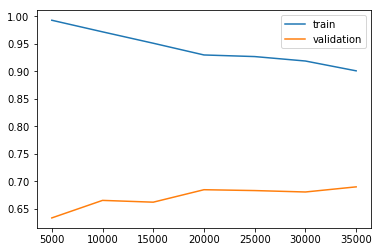

In [88]:
plt.plot(np.linspace(5000, 35000, 7), lc_train.mean(1), label='train')
plt.plot(np.linspace(5000, 35000, 7), lc_test.mean(1), label='validation')
plt.legend();

### Вывод
Выше используется кастомная кривая обучения, т.к. в процессе разбиения на фолды нужно применить препроцессинг (чтобы избежать переобучения).

Кривая обучения свидетельствует о том, что с ростом количества объектов качество модели повышается.
Однако, на лицо переобученность модели - т.к. разрыв между качеством на тренировочных и тестовых данных значителен.
Это значит, что нужно упрощать модель, либо устранив кодирование по целевой переменной, либо исключив часть признаков, либо усилить регуляризацию, либо все вместе.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [91]:
# balanced 
w1_train = np.float32(y_train*0+1)
w1_train[y_train==0] = np.sum(y_train==1)/np.sum(y_train==0)
# non churn to 0.25
w2_train = np.float32(y_train*0+1)
w2_train[y_train==0] = 0.25
# non churn to 0.5
w3_train = np.float32(y_train*0+1)
w3_train[y_train==0] = 0.5
# non churn to 0.75
w4_train = np.float32(y_train*0+1)
w4_train[y_train==0] = 0.75
# non churn to 0.95
w5_train = np.float32(y_train*0+1)
w5_train[y_train==0] = 0.9
# non churn to 1.5
w7_train = np.float32(y_train*0+1)
w7_train[y_train==0] = 1.5
# random 
w6_train = np.random.rand(y_train.shape[0])

In [95]:
X_train, X_valid = transform_xgb(X_train, X_valid, y_train)
fit_model = model.fit(X_train, y_train)
roc_auc_score(y_valid, fit_model.predict_proba(X_valid)[:, 1])

0.71943743552569206

In [96]:
fit_model = model.fit(X_train, y_train, sample_weight=w1_train)
roc_auc_score(y_valid, fit_model.predict_proba(X_valid)[:, 1])

# fit_model = model.fit(X_train, y_train, 
#                       early_stopping_rounds=20, eval_metric="auc", eval_set=[(X_valid, y_valid)], verbose=50,
#                       sample_weight=w1)

0.71542550719788855

In [97]:
fit_model = model.fit(X_train, y_train, sample_weight=w2_train)
roc_auc_score(y_valid, fit_model.predict_proba(X_valid)[:, 1])

0.71713843272832034

In [98]:
fit_model = model.fit(X_train, y_train, sample_weight=w3_train)
roc_auc_score(y_valid, fit_model.predict_proba(X_valid)[:, 1])

0.72005720207061263

In [99]:
fit_model = model.fit(X_train, y_train, sample_weight=w4_train)
roc_auc_score(y_valid, fit_model.predict_proba(X_valid)[:, 1])

0.7213821200546463

In [100]:
fit_model = model.fit(X_train, y_train, sample_weight=w5_train)
roc_auc_score(y_valid, fit_model.predict_proba(X_valid)[:, 1])

0.71765480804081749

In [101]:
fit_model = model.fit(X_train, y_train, sample_weight=w6_train)
roc_auc_score(y_valid, fit_model.predict_proba(X_valid)[:, 1])

0.71300801107796397

In [102]:
fit_model = model.fit(X_train, y_train, sample_weight=w7_train)
roc_auc_score(y_valid, fit_model.predict_proba(X_valid)[:, 1])

0.71437300768580214

### Вывод
Использование весов дает улучшение на доли процента.

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [45]:
transform_linear = partial(transform, encode='ohe', scaling=True, fill_num='mean', 
                           hc_drop=True, high_cardinality=HC, eb_k=HC_K, eb_f=HC_F,
                           to_drop=to_drop)

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=5000, random_state=42, stratify=target)
X_train, X_valid = transform_linear(X_train, X_valid, y_train)

In [47]:
from imblearn.under_sampling import TomekLinks, NearMiss, InstanceHardnessThreshold

In [48]:
# TomekLinks
tl = TomekLinks(return_indices=True, n_jobs=4)
_, _, idx_resampled = tl.fit_sample(X_train, y_train)

In [66]:
fit_model = model
fit_model.set_params(gamma=3, min_child_weight=1, reg_alpha=2, subsample=0.95)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=3, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=4, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=0, reg_alpha=2,
       reg_lambda=1.3, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.95, tree_method='gpu_hist')

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=5000, random_state=42, stratify=target)
X_train, X_valid = transform_xgb(X_train.iloc[idx_resampled, :], X_valid, y_train[idx_resampled])
fit_model = fit_model.fit(X_train, y_train[idx_resampled], early_stopping_rounds=20, eval_metric="auc", 
                      eval_set=[(X_valid, y_valid)], verbose=20)

[0]	validation_0-auc:0.664109
Will train until validation_0-auc hasn't improved in 20 rounds.
[20]	validation_0-auc:0.686229
[40]	validation_0-auc:0.700331
[60]	validation_0-auc:0.706095
[80]	validation_0-auc:0.708308
[100]	validation_0-auc:0.712377
[120]	validation_0-auc:0.715045
[140]	validation_0-auc:0.716919
[160]	validation_0-auc:0.717881
[180]	validation_0-auc:0.719823
[200]	validation_0-auc:0.720312
Stopping. Best iteration:
[193]	validation_0-auc:0.721287



In [11]:
# near miss 
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=5000, random_state=42, stratify=target)
X_train, X_valid = transform_linear(X_train, X_valid, y_train)

nm = NearMiss(version=2, return_indices=True, n_jobs=4)
_, _, idx_resampled = nm.fit_sample(X_train, y_train)

In [12]:
X_train.iloc[idx_resampled, :].shape, y_train[idx_resampled].shape

((5208, 262), (5208,))

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=5000, random_state=42, stratify=target)
X_train, X_valid = transform_xgb(X_train.iloc[idx_resampled, :], X_valid, y_train[idx_resampled])
fit_model = model.fit(X_train, y_train[idx_resampled], early_stopping_rounds=20, eval_metric="auc", 
                      eval_set=[(X_valid, y_valid)], verbose=20)

[0]	validation_0-auc:0.49777
Will train until validation_0-auc hasn't improved in 20 rounds.
[20]	validation_0-auc:0.482872
Stopping. Best iteration:
[1]	validation_0-auc:0.498145



In [15]:
# Cluster centroids
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=5000, random_state=42, stratify=target)
X_train, X_valid = transform_linear(X_train, X_valid, y_train)

cx = InstanceHardnessThreshold(return_indices=True, n_jobs=4)
_, _, idx_resampled = cx.fit_sample(X_train, y_train)

In [22]:
idx_resampled.shape

(18863,)

In [42]:
fit_model = model
fit_model.set_params(gamma=3, min_child_weight=1, reg_alpha=3, subsample=0.9)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=3, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=4, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=0, reg_alpha=3,
       reg_lambda=1.3, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9, tree_method='gpu_hist')

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(train, target, test_size=5000, random_state=42, stratify=target)
X_train, X_valid = transform_xgb(X_train.iloc[idx_resampled, :], X_valid, y_train[idx_resampled])
fit_model = fit_model.fit(X_train, y_train[idx_resampled], early_stopping_rounds=20, eval_metric="auc", 
                      eval_set=[(X_valid, y_valid)], verbose=20)

[0]	validation_0-auc:0.671297
Will train until validation_0-auc hasn't improved in 20 rounds.
[20]	validation_0-auc:0.682956
[40]	validation_0-auc:0.699372
[60]	validation_0-auc:0.701242
[80]	validation_0-auc:0.703414
[100]	validation_0-auc:0.704921
[120]	validation_0-auc:0.705794
[140]	validation_0-auc:0.707154
[160]	validation_0-auc:0.708016
[180]	validation_0-auc:0.708301
[200]	validation_0-auc:0.709302
[220]	validation_0-auc:0.711541
[240]	validation_0-auc:0.710642
Stopping. Best iteration:
[220]	validation_0-auc:0.711541



### Вывод
Были испробованы 3 стратегии under-sampling'а:
Tomek links, NearMiss и Instance Hardness Threshold.
Неплохо себя проявил метод Tomek links. При переподборе гиперпараметров (особенно повышении subsample) они дал небольшое улучшение на отложенной выборке.

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [19]:
model.n_estimators = 200

In [33]:
# -1 (default)
np.mean(cross_val(X_train_, y_train_, model, kf, transform_xgb))

Fold  0
Fold  1
Fold  2


0.69168834942408386

In [35]:
X_train, X_valid = transform_xgb(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

0.71943743552569206

In [89]:
# mean 
transform_fill = partial(transform_xgb, fill_num='mean')
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.70310256049977393

In [90]:
X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

0.71791444782111691

In [91]:
# median 
transform_fill = partial(transform_xgb, fill_num='median')
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.69504775091586757

In [92]:
X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

0.71378170277227915

### Вывод
Были испробованы 3 стратегии заполнения средних: отрицательным значением, средней и медианой.
Результаты на отложенной выборке и кросс-валидации разделились:
на большой выборке лучше себя показало заполнение минус единицей, на кросс-валидации средней.
Значит, стоит их проверить после отбора признаков и оптимизации гипермараметров.

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [163]:
# one hot encoding 
transform_fill = partial(transform_xgb, encode='ohe')
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.703119365533309

In [164]:
X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

0.71851388462932508

In [165]:
# binary encoding 
transform_fill = partial(transform_xgb, encode='bin')
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.70162243304387051

In [166]:
X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

0.71943743552569206

In [213]:
# no nan preprocessing
model.missing = -1
print(np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill)))
X_train, X_valid = transform_xgb(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
print(roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1]))
model.missing = None

Fold  0
Fold  1
Fold  2
0.730193382815
0.720143167814


In [167]:
# high cardinality supervised ratio
transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="sr", eb_k=50, eb_f=2)
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.57577614454687343

In [168]:
X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

0.59234811944126908

In [169]:
# high cardinality weight of evidence 
transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="woe", eb_k=50, eb_f=2)
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0


C:\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log


Fold  1


C:\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log


Fold  2


C:\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log


0.62600482734647489

In [170]:
X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

C:\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in log


0.64210456919545356

In [171]:
# high cardinality smoothing k=30, f=5
transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="smoothing", eb_k=30, eb_f=5)
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.59966963683474073

In [172]:
X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

0.60638260796832744

In [76]:
# high cardinality smoothing k=80, f=2
transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="smoothing", eb_k=80, eb_f=2)
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.72110511720579307

In [77]:
X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

0.73462026375219569

In [175]:
# high cardinality smoothing k=80, f=5
transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="smoothing", eb_k=80, eb_f=5)
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.59679721085142301

In [186]:
X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
model.fit(X_train, y_train)
roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1])

0.60427296214719195

C:\dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:173: RuntimeWarning: overflow encountered in exp


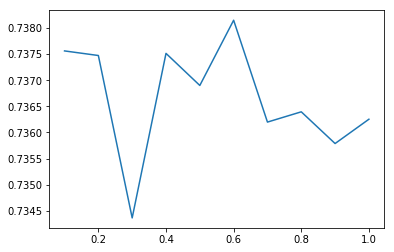

In [200]:
params = np.linspace(0.1, 1, 10)
auc_scores = []
for f in params:
    transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="smoothing", eb_k=80, eb_f=f)
    X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
    model.fit(X_train, y_train)
    auc_scores.append(roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1]))
    
plt.plot(params, auc_scores);

In [201]:
transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="smoothing", eb_k=80, eb_f=0.5)
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.72249520678078272

In [202]:
transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="smoothing", eb_k=80, eb_f=1)
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.72189215633046067

In [203]:
transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="smoothing", eb_k=80, eb_f=2)
np.mean(cross_val(X_train_, y_train_, model, kf, transform_fill))

Fold  0
Fold  1
Fold  2


0.72110511720579307

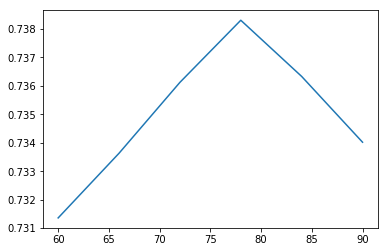

In [217]:
# K 
params = np.linspace(60, 90, 6)
auc_scores = []
for k in params:
    transform_fill = partial(transform_xgb, hc_drop=False, high_cardinality="smoothing", eb_k=k, eb_f=0.5)
    X_train, X_valid = transform_fill(X_train_, X_valid_, y_train_)
    model.fit(X_train, y_train)
    auc_scores.append(roc_auc_score(y_valid_, model.predict_proba(X_valid)[:, 1]))
    
plt.plot(params, auc_scores);

### Вывод
Для обработки пустых значений категориальных признаков использовалась перекодировка в отдельный уровень(-1) и отках от кодирования (XGBoost способен обрабатывать пустые значения самостоятельно). 
Лучший результат показало стандартное кодирование в -1 в сочетании с передачей его в XGBoost в качестве пустого значения.
Т.е. это по сути отказ как от заполнения пустых значений как категориальных, так и числовых переменных.

Для преобразования категориальных переменных сравнивались one hot и binary кодирование. Binary кодирование показало себя лучше, на таком же уровне как и отказ от кодирования. 

Также были опробованы разные варианты кодирования категориальных значения с большим числом уроней (high cardinality).
Здесь лучшим оказался метод замены уровней на соответствующие средние предсказываемых классов (со сглаживанием).
Лучшие параметры: k=78, f=0.5

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [133]:
# оптимальный препроцессинг 
opt_transform = partial(transform_xgb, eb_k=80, eb_f=0.5,
                        feature_dtypes=X_train_.dtypes, 
                        feature_names=X_train_.columns)
# оптимальная модель
opt_model = model.set_params(missing=-1, n_estimators=200)
X_train, X_valid = opt_transform(X_train_, X_valid_, y_train_)

In [134]:
# before
opt_model.fit(X_train, y_train_)
roc_auc_score(y_valid_, opt_model.predict_proba(X_valid)[:, 1])

0.74204874954693745

In [135]:
np.mean(cross_val(X_train_, y_train_, opt_model, kf, opt_transform))

Fold  0
Fold  1
Fold  2


0.72464587328326413

In [59]:
class RFEClass():
    
    def __init__(self, model, scorer=roc_auc_score, step=1, min_features=20):
        
        self.model = model
        self.step = step
        self.scorer = scorer
        self.min_features = min_features
        
    def fit(self, X_train, X_valid, y_train, y_valid):
        
        # init vars
        self.X_train_ = X_train
        self.X_valid_ = X_valid
        self.y_train_ = y_train
        self.y_valid_ = y_valid        
        
        n_features = []
        scores = []
        support = np.full(X_train.shape[1], 1)
        dropped = []
        keep = []
                
        # fit 
        
        while self.X_train_.shape[1] > self.min_features:
            
            self.model.fit(self.X_train_, self.y_train_)
            
            n_features.append(self.X_train_.shape[1])
            print(n_features[-1]) 
            scores.append(self.scorer(self.y_valid_, 
                                      self.model.predict_proba(self.X_valid_)[:, 1]
                                     ))
            
            coef = self.model.feature_importances_
            
            if np.sum(coef==coef.min()) > self.step:
                to_drop = np.random.choice(np.where(coef==coef.min())[0], self.step)
            else:
                to_drop = np.argsort(coef)[:self.step]

            drop_cols = self.X_train_.columns[to_drop]    
            drop_vec = np.isin(self.X_train_.columns, drop_cols)
            support += np.int32(np.isin(X_train.columns, drop_cols))
            keep.append(support.copy())
            
            # update X
            self.X_train_ = self.X_train_.loc[:, ~drop_vec]
            self.X_valid_ = self.X_valid_.loc[:, ~drop_vec]                            
            
            # filter zero importances
            
#             self.X_train_ = X_train.loc[:, coef!=0]
#             self.X_valid_ = X_valid.loc[:, coef!=0]
        
        # assign results
        self.n_features_ = n_features
        self.scores_ = scores 
        self.support_ = support
        self.keep_ = keep
        
        return self 
    

In [60]:
rfe = RFEClass(opt_model, step=5)
rfe.fit(X_train, X_valid, y_train, y_valid)

226
221
216
211
206
201
196
191
186
181
176
171
166
161
156
151
147
142
138
133
128
124
120
115
111
106
101
96
91
86
81
76
71
66
61
56
51
46
41
36
31
26
21


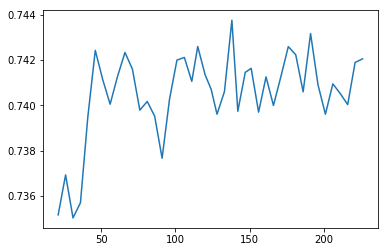

In [61]:
plt.plot(rfe.n_features_, rfe.scores_)

In [80]:
mask = np.isin(np.arange(len(rfe.scores_)), np.argsort(np.array(rfe.scores_))[-5:])
best_features = np.array(rfe.keep_)[mask]

In [64]:
for i in range(5):
    cv_transform = partial(opt_transform, keep=list(X_train.columns[best_features[i]==1]))
    print(np.mean(cross_val(X_train_, y_train_, opt_model, kf, cv_transform)))    

Fold  0
Fold  1
Fold  2
0.72526391581
Fold  0
Fold  1
Fold  2
0.724724032418
Fold  0
Fold  1
Fold  2
0.725985231666
Fold  0
Fold  1
Fold  2
0.72558657798
Fold  0
Fold  1
Fold  2
0.725414923546


In [68]:
rfe_best = list(X_train.columns[best_features[2]==1])

In [71]:
def pickle_dump(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

pickle_dump(rfe_best, "rfe_best")

In [72]:
# Boruta 
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=4, class_weight='balanced', max_depth=7)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, max_iter=150)

In [73]:
boruta_selector.fit(np.array(X_train), y_train)

Iteration: 	1 / 150
Confirmed: 	0
Tentative: 	226
Rejected: 	0
Iteration: 	2 / 150
Confirmed: 	0
Tentative: 	226
Rejected: 	0
Iteration: 	3 / 150
Confirmed: 	0
Tentative: 	226
Rejected: 	0
Iteration: 	4 / 150
Confirmed: 	0
Tentative: 	226
Rejected: 	0
Iteration: 	5 / 150
Confirmed: 	0
Tentative: 	226
Rejected: 	0
Iteration: 	6 / 150
Confirmed: 	0
Tentative: 	226
Rejected: 	0
Iteration: 	7 / 150
Confirmed: 	0
Tentative: 	226
Rejected: 	0
Iteration: 	8 / 150
Confirmed: 	28
Tentative: 	22
Rejected: 	176


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 150
Confirmed: 	28
Tentative: 	22
Rejected: 	176


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 150
Confirmed: 	28
Tentative: 	22
Rejected: 	176


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 150
Confirmed: 	28
Tentative: 	22
Rejected: 	176


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 150
Confirmed: 	28
Tentative: 	15
Rejected: 	183


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 150
Confirmed: 	28
Tentative: 	15
Rejected: 	183


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 150
Confirmed: 	28
Tentative: 	15
Rejected: 	183


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 150
Confirmed: 	28
Tentative: 	15
Rejected: 	183


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 150
Confirmed: 	28
Tentative: 	15
Rejected: 	183


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 150
Confirmed: 	28
Tentative: 	15
Rejected: 	183


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 150
Confirmed: 	28
Tentative: 	14
Rejected: 	184


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 150
Confirmed: 	29
Tentative: 	13
Rejected: 	184


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 150
Confirmed: 	29
Tentative: 	13
Rejected: 	184


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 150
Confirmed: 	29
Tentative: 	12
Rejected: 	185


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 150
Confirmed: 	29
Tentative: 	9
Rejected: 	188


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 150
Confirmed: 	29
Tentative: 	9
Rejected: 	188


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 150
Confirmed: 	29
Tentative: 	9
Rejected: 	188


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 150
Confirmed: 	29
Tentative: 	9
Rejected: 	188


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	26 / 150
Confirmed: 	30
Tentative: 	8
Rejected: 	188


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	27 / 150
Confirmed: 	30
Tentative: 	8
Rejected: 	188


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	28 / 150
Confirmed: 	30
Tentative: 	8
Rejected: 	188


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	29 / 150
Confirmed: 	30
Tentative: 	6
Rejected: 	190


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	30 / 150
Confirmed: 	30
Tentative: 	6
Rejected: 	190


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	31 / 150
Confirmed: 	30
Tentative: 	6
Rejected: 	190


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	32 / 150
Confirmed: 	30
Tentative: 	4
Rejected: 	192


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	33 / 150
Confirmed: 	30
Tentative: 	4
Rejected: 	192


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	34 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	35 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	36 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	37 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	38 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	39 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	40 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	41 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	42 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	43 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	44 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	45 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	46 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	47 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	48 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	49 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	50 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	51 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	52 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	53 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	54 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	55 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	56 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	57 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	58 / 150
Confirmed: 	30
Tentative: 	3
Rejected: 	193


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	59 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	60 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	61 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	62 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	63 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	64 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	65 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	66 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	67 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	68 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	69 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	70 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	71 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	72 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	73 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	74 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	75 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	76 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	77 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	78 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	79 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	80 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	81 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	82 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	83 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	84 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	85 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	86 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	87 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	88 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	89 / 150
Confirmed: 	30
Tentative: 	2
Rejected: 	194


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	90 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	91 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	92 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	93 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	94 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	95 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	96 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	97 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	98 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	99 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	100 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	101 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	102 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	103 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	104 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	105 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	106 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	107 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	108 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	109 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	110 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	111 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	112 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	113 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	114 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	115 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	116 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	117 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	118 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	119 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	120 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	121 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	122 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	123 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	124 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	125 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	126 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	127 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	128 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	129 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	130 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	131 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	132 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	133 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	134 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	135 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	136 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	137 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	138 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	139 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	140 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	141 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	142 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	143 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	144 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	145 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	146 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	147 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	148 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195
Iteration: 	149 / 150
Confirmed: 	30
Tentative: 	1
Rejected: 	195


BorutaPy finished running.

Iteration: 	150 / 150
Confirmed: 	30
Tentative: 	0
Rejected: 	195


C:\dev\Anaconda3\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=112, n_jobs=4, oob_score=False,
            random_state=<mtrand.RandomState object at 0x000001C71EE67708>,
            verbose=0, warm_start=False),
     max_iter=150, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x000001C71EE67708>,
     two_step=True, verbose=2)

In [75]:
boruta_best = list(X_train.columns[boruta_selector.support_])
cv_transform = partial(opt_transform, keep=boruta_best)
print(np.mean(cross_val(X_train_, y_train_, opt_model, kf, cv_transform)))    

Fold  0
Fold  1
Fold  2
0.725882694533


In [76]:
def pickle_dump(obj, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

pickle_dump(boruta_best, "boruta_best")

In [78]:
np.intersect1d(boruta_best, rfe_best).shape

(30,)

### Вывод
Были испробованы методы RFE и Boruta.
Оптимальное число переменных равно 133 и 30 соответственно.
Оба варианта хороши и повышают качество модели.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [137]:
X_train = X_train.loc[:, rfe_best]
X_valid = X_valid.loc[:, rfe_best]

In [139]:
hyperopt_model = XGBClassifier(n_jobs=4, tree_method='gpu_hist', predictor = "cpu_predictor", objective="binary:logistic",
                      missing=-1, 
                      n_estimators=200, learning_rate=0.05,
                      max_depth=4, gamma=10, min_child_weight=2, reg_alpha=2, reg_lambda=1.3,
                      subsample=.8, colsample_bytree=.8,
                      scale_pos_weight=1
                     )

In [106]:
cv_transform = partial(opt_transform, keep=rfe_best)
pickle_dump(cv_transform, "opt_transform")

In [111]:
def pickle_load(file_name):
    with open(file_name, 'rb') as f:
        data = pickle.load(f)
    return data

best_hp = pickle_load('best')
trials_hp = pickle_load('trials')

In [140]:
# convert space to params 

from hyperopt import space_eval, hp
space = {}
space['n_estimators'] = hp.randint('n_estimators', 20)*10 + 100
space['max_depth'] = hp.choice('max_depth', [3,4,5,6])
space['learning_rate'] = hp.uniform('learning_rate', 0.01, 0.1)
space['gamma'] = hp.randint('gamma', 5)*2
space['min_child_weight'] = hp.uniform('min_child_weight', 1.5, 2.5)
space['scale_pos_weight'] = hp.uniform('scale_pos_weight', 0.5, 1.5)
space['subsample'] = hp.uniform('subsample', 0.7, 0.9)
space['colsample_bytree'] = hp.uniform('colsample_bytree', 0.7, 0.9)
space['reg_alpha'] = hp.uniform('reg_alpha', 1, 3)
space['reg_lambda'] = hp.uniform('reg_lambda', 1, 2)

opt_params = space_eval(space, best_hp)
hyperopt_model.set_params(**opt_params)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7004848702899348, gamma=4,
       learning_rate=0.043937376458117156, max_delta_step=0, max_depth=4,
       min_child_weight=2.3606387519121763, missing=-1, n_estimators=170,
       n_jobs=4, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=0,
       reg_alpha=1.362192488318045, reg_lambda=1.2675794323196827,
       scale_pos_weight=0.6121411226959748, seed=None, silent=True,
       subsample=0.7637859900410551, tree_method='gpu_hist')

In [159]:
cv_transform = partial(opt_transform, keep=boruta_best)

In [160]:
np.mean(cross_val(train, target, hyperopt_model, kf, cv_transform))

Fold  0
Fold  1
Fold  2


0.73684591485627049

In [161]:
np.mean(cross_val(train, target, opt_model, kf, cv_transform))

Fold  0
Fold  1
Fold  2


0.73351175865337426

### Вывод
Для подбора гиперпараметров был использован hyperopt, на кросс-валидации по полной тренировочной выборке.
Использование оптимальных параметров повысило AUC на 0.3 процента.
Скрипт с кодом в можно найти в приложении.

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [184]:
X_train, X_valid = cv_transform(X_train_, X_valid_, y_train_)

In [186]:
hyperopt_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7004848702899348, gamma=4,
       learning_rate=0.043937376458117156, max_delta_step=0, max_depth=4,
       min_child_weight=2.3606387519121763, missing=-1, n_estimators=170,
       n_jobs=4, nthread=None, objective='binary:logistic',
       predictor='cpu_predictor', random_state=0,
       reg_alpha=1.362192488318045, reg_lambda=1.2675794323196827,
       scale_pos_weight=0.6121411226959748, seed=None, silent=True,
       subsample=0.7637859900410551, tree_method='gpu_hist')

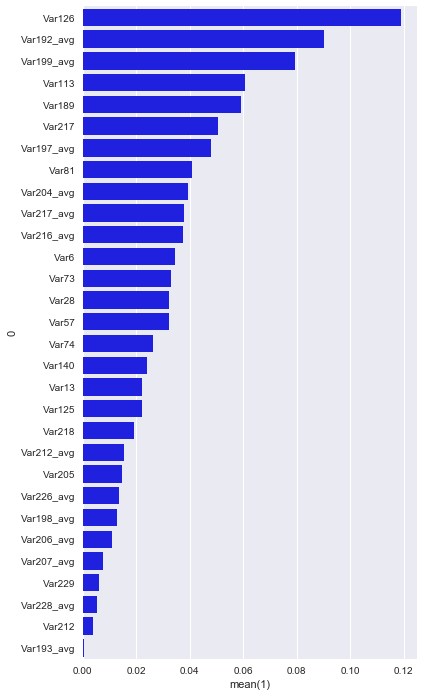

In [213]:
import seaborn as sns
fe = pd.DataFrame(sorted(list(zip(X_train.columns, hyperopt_model.feature_importances_)), key = lambda x: x[1], reverse=True))

plt.figure(figsize=(6,12))
sns.barplot(fe.loc[:, 1], fe.loc[:, 0], color='b')

Наиболее важные фичи:
* Var126
* Var192_avg
* Var199_avg
* Var113
* Var189

'avg' означает, что это категориальный признак, уровни которого перекодированы по целевой переменной

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [220]:
X, _ = cv_transform(train, test, target)
hyperopt_model.fit(X, target)
pred_proba = hyperopt_model.predict_proba(X)[:, 1]

In [221]:
roc_auc_score(target, pred_proba)

0.80193760360905098

In [264]:
cutoff_metrics(target, pred_proba, np.linspace(0.05, 0.15, 11))

f1: 0.277	recall: 0.736	precision: 0.171	acc: 0.714	cutoff: 0.050 
f1: 0.301	recall: 0.664	precision: 0.195	acc: 0.771	cutoff: 0.060 
f1: 0.317	recall: 0.589	precision: 0.217	acc: 0.811	cutoff: 0.070 
f1: 0.327	recall: 0.521	precision: 0.238	acc: 0.840	cutoff: 0.080 
f1: 0.334	recall: 0.463	precision: 0.261	acc: 0.863	cutoff: 0.090 
f1: 0.341	recall: 0.419	precision: 0.288	acc: 0.880	cutoff: 0.100 
f1: 0.344	recall: 0.380	precision: 0.314	acc: 0.892	cutoff: 0.110 
f1: 0.340	recall: 0.345	precision: 0.335	acc: 0.900	cutoff: 0.120 
f1: 0.332	recall: 0.310	precision: 0.357	acc: 0.907	cutoff: 0.130 
f1: 0.320	recall: 0.279	precision: 0.376	acc: 0.912	cutoff: 0.140 
f1: 0.313	recall: 0.256	precision: 0.403	acc: 0.916	cutoff: 0.150 


In [277]:
pred = np.int32(pred_proba > 0.11)
FN = np.where(np.logical_and(pred != target, target==1), pred_proba, -1)
FP = np.where(np.logical_and(pred != target, target==0), pred_proba, -1)

In [304]:
# FN с наименьшей вероятностью
X[np.logical_and(FN != -1, FN < 0.012)].iloc[:, :15]

,Var6,Var13,Var28,Var57,Var73,Var74,Var81,Var113,Var125,Var126,Var140,Var189,Var205,Var212,Var217
784,672.0,-1.0,253.52,2.077761,30,-1.0,176606.40,79187.60,-1.0,-30.0,-1.0,-1.0,2,33,5367
2040,833.0,112.0,253.52,4.548173,76,0.0,210234.90,333704.80,18792.0,-28.0,20.0,336.0,2,33,1004
3152,1253.0,1304.0,166.56,0.622089,58,161.0,4513.29,13988.16,81045.0,-30.0,9620.0,294.0,3,44,13785
3224,1750.0,228.0,271.20,2.964110,160,63.0,20975.91,51163.20,18621.0,-26.0,490.0,-1.0,1,5,5698
4135,4879.0,1684.0,186.64,4.771630,228,70.0,24744.03,-685864.00,3753.0,-22.0,620.0,336.0,2,48,12442
4309,1246.0,4712.0,176.56,2.390088,164,175.0,20317.98,53568.00,45621.0,-30.0,1855.0,-1.0,1,27,13816
7761,7476.0,9136.0,166.56,2.076266,208,826.0,12274.53,-502196.00,86445.0,-20.0,1610.0,-1.0,2,63,13665
9757,1239.0,660.0,200.00,2.738731,34,294.0,43230.30,-1050248.00,17523.0,-20.0,535.0,-1.0,2,33,2495
15693,3409.0,2352.0,120.40,3.392651,106,189.0,42474.30,-27879.00,63243.0,-24.0,505.0,-1.0,2,27,10076
19207,840.0,2556.0,289.20,3.208502,174,56.0,182039.10,287952.40,49032.0,-24.0,2255.0,-1.0,2,43,2177


In [298]:
# FP с наибольшей вероятностью
X[FP >0.4]

,Var6,Var13,Var28,Var57,Var73,Var74,Var81,Var113,Var125,Var126,...,Var198_avg,Var199_avg,Var204_avg,Var206_avg,Var207_avg,Var212_avg,Var216_avg,Var217_avg,Var226_avg,Var228_avg
6063,105.0,0.0,255.68,4.262551,16,0.0,270448.20,326182.80,0.0,-8.0,...,0.074400,0.074400,0.090847,0.100563,0.083217,0.090769,0.074400,0.159574,0.094799,0.086605
6984,280.0,0.0,20.08,6.951719,14,0.0,40493.70,-103952.00,0.0,-10.0,...,0.074400,0.074400,0.089623,0.091598,0.083217,0.090769,0.230769,0.276786,0.094799,0.086605
9276,574.0,0.0,199.52,0.134373,22,0.0,149919.60,50550.80,0.0,-1.0,...,0.074400,0.074400,0.105327,0.100563,0.083217,0.090769,0.074400,0.276786,0.094799,0.086605
11688,4620.0,0.0,166.56,2.747063,48,0.0,53759.70,15804.44,4428.0,24.0,...,0.073409,0.141593,0.059197,0.091598,0.075130,0.069747,0.074400,0.276786,0.064721,0.074400
12899,105.0,0.0,264.80,0.090365,14,0.0,207157.80,363336.00,0.0,-10.0,...,0.074400,0.126582,0.085020,0.091598,0.083217,0.090769,0.074400,0.276786,0.089236,0.086605
14138,147.0,0.0,266.40,1.129460,18,0.0,237746.70,80322.00,0.0,-8.0,...,0.074400,0.175824,0.084239,0.091598,0.083217,0.090769,0.080169,0.144444,0.090164,0.086605
16831,105.0,0.0,230.56,3.529160,18,0.0,409815.00,-25587.84,0.0,-8.0,...,0.074400,0.074400,0.077035,0.091598,0.083217,0.090769,0.146832,0.140845,0.073546,0.086605
21633,784.0,0.0,389.60,2.498398,26,0.0,122172.00,97558.40,0.0,-1.0,...,0.074400,0.074400,0.077185,0.069571,0.083217,0.090769,0.192708,0.276786,0.073243,0.086605
22061,714.0,312.0,31.44,4.084811,34,7.0,220342.20,119772.00,15075.0,-1.0,...,0.074400,0.138889,0.080189,0.100563,0.083217,0.090769,0.192708,0.276786,0.078963,0.086605
28807,707.0,4.0,589.60,5.622303,42,0.0,199304.10,5844040.00,396.0,-1.0,...,0.074400,0.074400,0.134357,0.100563,0.083217,0.090769,0.088751,0.074400,0.094799,0.086605


### Вывод
На примерах объектов, дающих наибольшую ошибку в классификации видно, что причиной этого являются аномальные значения признаков, Var81, Var113, Var28. Это наталкивает на идею логарифмировать некоторые из числовых признаков, чтобы нормализовать их распределение.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

**Препроцессинг**: 
* преобразование пустых значений в -1
* переводировка категориальных признаков с числом категорий больше 10 при помощи таргет-кодирования со сглаживанием, с параметрами K = 80, F = 0.5, новые признаки называются как старые, но с добавлением постфикса '_avg'
* отбор признаков алгоритмом Boruta, следующие 30 признаков:

Var6, Var13, Var28, Var57, Var73, Var74, Var81, Var113, Var125, Var126, Var140, Var189, Var205, Var212, Var217, Var218, Var229, Var192_avg, Var193_avg, Var197_avg, Var198_avg, Var199_avg, Var204_avg, Var206_avg, Var207_avg, Var212_avg, Var216_avg, Var217_avg, Var226_avg, Var228_avg

**Модель**: XGBoost c гиперпараметрами:

* objective='binary:logistic'
* max_depth=4, learning_rate=0.044, n_estimators=170 
* colsample_bytree=0.7, subsample=0.76
* gamma=4, min_child_weight=2.36, reg_alpha=1.36, reg_lambda=1.27
* missing=-1, scale_pos_weight=0.61


10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

1. Закодировать пустые ответы не в -1 а в еще меньшее значение, т.к. оказалось, что есть числовые признаки с отрицательными значениями
2. Использовать ансамбли моделей 
3. Преобразовать числовые признаки к нормальному распределению
4. Создать новые признаки (Feature Engineering) при помощи комбинации старых с наибольшей важностью, затем заново отобрать лучшие признаки